# Frequency regulation — Simulating the swing equation and the effect of primary reserve (FCR)

This notebook contains a **temporal simulation of grid frequency**, assuming a simple swing equation,
at the time of **power imbalance** event (electric power consumption ≠ injection, e.g. when loosing one large generation unit).
This triggers **primary frequency regulation** (also called FCR: Frequency Containment Reserve) to stabilize the grid.

This model can show:
- effect of the absence of primary frequency regulation → grid blackout (or over-frequency)
- effect of main parameters: imbalance intensity, grid inertia, regulation gain
- effect of imperfect regulation (lag in the regulation) → oscillations

Left to be done:
- add a nice illustration of swing equation with frequency regulation feedback
- allow the perturbation to be transient (door shaped)
- have a "hidden code" version of this notebook

Pierre Haessig, september 2023, CC-BY

In [1]:
import numpy as np
from numpy import pi
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from ipywidgets import interact

## Preamble: models and formulas used

### Swing equation

From the law of motion:
$$ J \Omega \frac{d\Omega}{dt} = P_{mech} - P_{elec} $$

then introducing the inertia “constant”
$$ H = \frac{J \Omega^2}{2 S_{tot}} $$

yields the normalized swing equation

$$2H \frac{1}{Ω}\frac{dΩ}{dt} = + \frac{ΔP}{S_{tot}}$$

where $ΔP = P_{mech} - P_{elec} $ is an excess of mechanical power of the shaft.

Initial RoCoF (from normalized swing equation):

$$\frac{df}{dt} = +\frac{f_0}{2H}\frac{ΔP}{S_{tot}}$$

### Primary reserve (FCR)

FCR: Frequency Containment Reserve

Feedback law:
$$\Delta P_{FCR} = -K.\Delta f$$

with $\Delta f = f - f_0$ and $K$ the FCR feedback gain.

Also, in steady state, for a constant excess of electric load $P_{load}$, the final value of the frequency (once FCR is fully deployed) comes from the inversion of the gain formula:

$$\Delta f_{final} = -\Delta P_{load}/K$$


Often, the FCR gain is expressed as an inverse normalized FCR gain (smaller is stronger):
$$s = P_{rated}/(K.f_0)$$

This yields the FCR gain (larger is stronger):
$$K = P_{rated}/(s.f_0) \;\text{ in MW/Hz} $$

## Simulation code

Constants

In [2]:
# Base frequency
f0 = 50 # Hz
Ω0 = 2*pi*f0

# Simulation duration: initial and final time
t_ini=-1 # s
t_fin=10 # s

### Simulation function

In [3]:
def sim_freq_response(ΔP_load, H, s, τ_fcr, fcr, fcr_lag):
    """
    Simulate frequency response from FCR

    Parameters:
    ΔP_load: excess of consumption (in per-unit)
    H: inertia constant (s) >0
    s: FCR regulation inverse gain  (a few %) > 0
    τ_fcr: FCR first order time constant (s) > 0

    Booleans:
    fcr: activation of FCR, True of False
    fcr_lag: activation of FCR response lag, True or False

    Returns t, f, P_fcr, f_lim
    """
    # Constants and parameters
    Sg = 1 # so that ΔP is in pu
    J = 2*H*Sg/Ω0**2
    
    if fcr:
        K = Sg/(f0*s)
        f_lim = f0 - ΔP_load/K
    else:
        K = 0.0
        f_lim = 0 # 0 Hz = blackout
    
    def fder(t, x):
        """ODE dynamics for grid with optional frequency regulation
        """
        f = x[0]
        Δf = f-f0
        Ω = 2*pi*f
        
        if fcr_lag:
            P_fcr = x[1]
            # first order filter of FCR power
            P_fcr_dot = (-K*Δf - P_fcr)/τ_fcr
        else:
            P_fcr = -K*Δf
    
        P_load = 0 if t<0 else ΔP_load # excess of electric load with respect of mechanical power
        ΔP = -P_load + P_fcr

        # Swing equation:
        Ω_dot = ΔP/(J*Ω)
        f_dot = Ω_dot/(2*pi)

        if fcr_lag:
            x_dot = (f_dot, P_fcr_dot)
        else:
            x_dot = (f_dot,)
        
        return x_dot

    # Initial conditions
    f_ini = 50 # Hz
    if fcr_lag:
        P_fcr_ini = 0 # MW
        x_ini = (f_ini, P_fcr_ini)
    else:
        x_ini = (f_ini,)

    # Solve ODE:
    sol = solve_ivp(fder, (t_ini, t_fin), x_ini,
                    method='BDF', max_step=(t_fin-t_ini)/100, rtol=1e-4)
    # Extract simulation output
    f = sol.y[0]
    if fcr_lag:
        P_fcr =  sol.y[1]
    else:
        P_fcr = -K*(f-f0)
    return sol.t, f, P_fcr, f_lim

t, f, P_fcr, f_lim = sim_freq_response(ΔP_load=0.1, H=5, s=0.05, τ_fcr=1, fcr=True, fcr_lag=True)
f[-1], f_lim, P_fcr[-1] 

(49.750042468601436, 49.75, 0.09932313072993189)

### Helper

In [5]:
def find_nadir(f):
    """find the frequency nadir in the vector `f`
    Returns (i_nadir, f_nadir) which are (None, None) if no nadir is found
    """
    i_min = np.argmin(f)

    if i_min < (len(f)-1) and i_min>0 and f[i_min]<=f[-1]-0.001:
        i_nadir = i_min
        f_nadir = f[i_min]
    else:
        i_nadir = None
        f_nadir = None
    
    return i_nadir, f_nadir

find_nadir([50.0, 49.0, 49.5, 49.7]), find_nadir([50, 49, 48, 47]), find_nadir([50, 50, 50]), find_nadir([50, 49, 49.0001])

((1, 49.0), (None, None), (None, None), (None, None))

### Plot function

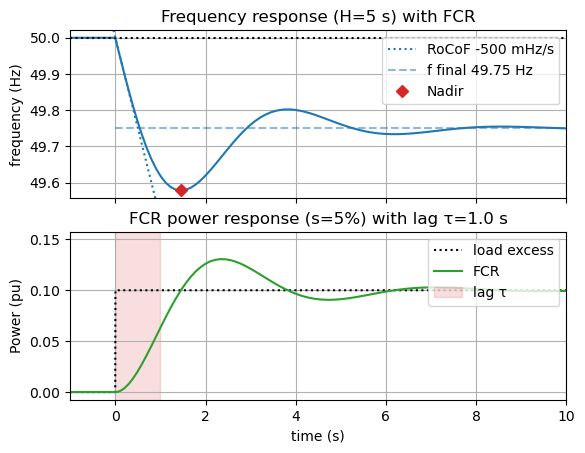

In [6]:
def plot_freq_response(t, f, P_fcr, f_lim,
                       ΔP_load, H, s, τ_fcr, fcr, fcr_lag,
                       f_min=None, P_max=None):
    """Plot frequency response.

    Parameters:
    - Simulation solution should be passed as t, f, P_fcr, f_lim (output of `sim_freq_response`)
    - Simulation parameters should be passed as ΔP_load, H, s, τ_fcr, fcr, fcr_lag (params of `sim_freq_response`)
    - vertical axis limits can be can be optionally forced with `f_min` and `P_max`.

    Returns fig, (ax1, ax2)
    """
    margin = 0.05 # margins for min and max values of axis limits

    P_load = np.where(t<0, 0, ΔP_load)
    
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    
    ### 1) Frequency plot ######
    title_f = f'Frequency response (H={H:.0f} s)'
    title_f += ' with FCR' if fcr else ' *without* FCR'
    
    if f_min is None:
        f_min = np.min(f)

    ax1.plot(t, f, '-')
    ax1.axhline(f0, ls=':', color='k')

    # Initial RoCoF linear trend:
    RoCoF = -f0 /(2*H) * ΔP_load
    RoCoF_label = f'RoCoF {RoCoF*1000:.0f} mHz/s'
    ax1.axline((0, f0), slope=RoCoF, ls=':', label=RoCoF_label)

    # Final frequency with FCR alone
    if fcr:
        ax1.plot((0, t_fin),(f_lim, f_lim), 'C0--', alpha=0.5, label=f'f final {f_lim:.2f} Hz')
    
    # Nadir:
    i_nadir, f_nadir = find_nadir(f)
    if i_nadir is not None:
        t_nadir = t[i_nadir]
        ax1.plot(t_nadir, f_nadir, 'D', color='tab:red', label='Nadir')

    # 0 Hz limit
    ax1.axhspan(-10, 0, color='black', alpha=0.7)

    # Blackout
    if f[-1] < f0*1e-3: # ~0 Hz
        ax1.axvspan(t[-1], t_fin, color='tab:red', alpha=0.5, label='blackout')
    
    # Annotations, grid and legend
    f_max = f0 if ΔP_load>=0 else f0+(f0-f_min) # show overspeed
    δf = (f0 - f_min)*margin # freq axis margin
    
    ax1.set(
        title=title_f,
        ylabel='frequency (Hz)', 
        ylim=(f_min-δf, f_max+δf),
        xlim=(t_ini, t_fin)
    )
    ax1.grid()
    ax1.legend(loc='upper right')    
    
    
    ### 2) Power plot ######
    title_P = 'FCR power response'
    if fcr:
        title_P += f' (s={s:.0%})'
        title_P += f' with lag τ={τ_fcr:.1f} s' if fcr_lag else ''
    else:
        title_P += ' (inactive)'

    ax2.plot(t, P_load, 'k:', label='load excess')
    ax2.plot(t, P_fcr, 'C2-', label='FCR')
    if fcr_lag:
        ax2.axvspan(0, τ_fcr, alpha=0.15, color='tab:red', label='lag τ')
    

    # Annotations, grid and legend
    ax2.set(
        title=title_P,
        xlabel='time (s)',
        ylabel='Power (pu)',
    )
    if P_max is not None:
        δP = P_max*margin
        P_min = 0 if ΔP_load>=0 else -P_max
        ax2.set_ylim(P_min-δP, P_max+δP)
    ax2.grid()
    ax2.legend(loc='upper right') 
    
    return fig, (ax1, ax2)

sim_params = dict(ΔP_load=0.1, H=5, s=0.05, τ_fcr=1,
              fcr=True, fcr_lag=True)

t, f, P_fcr, f_lim = sim_freq_response(**sim_params)

plot_freq_response(t, f, P_fcr, f_lim,
                   **sim_params,
                   P_max=0.15);

### Interactive plot function

In [7]:
def freq_response_interact(ΔP_load=0.1, H=1, s=0.10, τ_fcr=1,
                           fcr=False, fcr_lag=False, zoom_freq=False):
    """interactive plot of frequency response. meant to be given to `ipywidgets.interact`
    """
    # 1) Simulate
    sim_params = dict(ΔP_load=ΔP_load, H=H, s=s, τ_fcr=τ_fcr,
                      fcr=fcr, fcr_lag=fcr_lag)
    t, f, P_fcr, f_lim = sim_freq_response(**sim_params)

    # 2) Plot
    f_min = 49 if zoom_freq else 0 # Hz
    P_max = 0.14
    plt.close('all')
    fig, (ax1, ax2) = plot_freq_response(
        t, f, P_fcr, f_lim,
        **sim_params,
        f_min=f_min, P_max=P_max)

---

## Interactive experiment story

*Intructions: run the cell below ("Run" button with the triangle icon)*

### 1) Without frequency regulation
The frequency transient simulation starts without primary reserve (`fcr` off), with a full scale for frequency (0 to 50 Hz with `zoom_freq` off).
Initial frequency is at the nominal value 50 Hz.
You can explore the effect on the frequency of:

- intensity of power mismatch (excess of consumption `ΔP_load`), which can be negative in case of a excess of production
- grid inertia (`H` is seconds)
   
Both affect the rate of change of the frequency (“RoCoF”, or *slope* of the frequency trajectory). If the frequency reaches 0, this is a **blackout**(*).
And without frequency regulation, except if the power mismatch is strictly 0, it's only a matter of time becore crashing the grid (with blackout or over-frequency).

### 2) With frequency regulation

Then zoom closer to nominal frequency (`zoom_freq` → on) and **activate the primary frequency regulation** (`fcr` → on).
Witness the **stabilization of the grid frequency**, but *not at its nominal value*. 
You can explore the effect of:

- regulation inverse gain `s` (smaller means stronger regulation): affects the final frequency value, but not the initial rate of change (RoCoF)
- grid inertia (`H` is seconds): affects the initial rate of change (RoCoF) as without FCR, but no effect of the final value
- intensity of power mismatch (excess of consumption `ΔP_load`): affects both the final frequency value, and the initial RoCoF

Before going on, set `H` to a realistic value of about 4 to 8 seconds and `s` to 5%.

### 3) With imperfect frequency regulation (lag)

Finally, to get a realistic frequency trajectory, we should account of the slowness of the devices (often: steam or gas turbines) which contribute to the frequency regulation. **Activate the regulation lag** (`fcr_lag` → on). Witness the **frequency oscillations** before stabilization. An important value to monitor is the frequency nadir, that is the smallest transient value. It should be kept above the threshold of the automatic devices which disconnect consumers in case of low frequency (see (*) below). You can explore the *opposing* effects of:

- inertia time constant `H`: the larger, the less oscillations and thus the higher nadir
- frequency regulation lag time constant `τ_fcr`: the larger (i.e. longer lag), the more oscillations and thus the lower nadir (→ risk of disconnecting some consumers)

(*) About blackout: in real grids, emergency protection would disconnect loads before reaching 0 Hz to prevent the blackout of the core network, which can be long to recover (hours to days). However, this still means blackout for consumers.

In [10]:
interact(freq_response_interact,
    ΔP_load=(-0.2, 0.2, 0.05),
    H=(1e-3, 8, 1),
    s=(1e-4, 0.10, 0.01),
    τ_fcr=(1e-3, 2, 0.5));

interactive(children=(FloatSlider(value=0.1, description='ΔP_load', max=0.2, min=-0.2, step=0.05), FloatSlider…